# Extra libraries to install

In [1]:
%pip install prophet seaborn plotly pandas==1.3.5 numpy==1.24.3 matplotlib scikit-learn tensorflow sands urllib3==1.26.15 pydot pydot_ng pydotplus chardet==3.0.4 graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
print(sys.path)

['/home/gpaasch/ml4nce/UC1', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/gpaasch/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/gpaasch/.ipython']


# Drive connection and path definition

In [3]:
sys.path.insert(0, '/home/gpaasch/ml4nce')
print(sys.path)
path_files ='/home/gpaasch/ml4nce/UC1/'

['/home/gpaasch/ml4nce', '/home/gpaasch/ml4nce/UC1', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/gpaasch/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/gpaasch/.ipython']


# Import libraries

In [4]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
from SANDS import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
import pydot
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy

2024-05-20 19:03:53.930572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 19:03:54.537085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data generation

If you want to generate new data, run the following cells, otherwise, simply load the existing csv file. Either way, the result will be the same, the metric_df data frame with the required data.

In [5]:
parameters1 = {
        'time_delta':5
    }

In [6]:
print(sands.__file__)
metric_df = sands.generate_device_metric_time_range(datetime.now(),datetime.now()+timedelta(days=30),parameters1,['PE-4'],['bng_subscribers'])


/home/gpaasch/ml4nce/SANDS/sands.py


In [7]:
metric_df.to_csv(join(path_files,'bng_subscribers_metric.csv'))

In [8]:
metric_df=pd.read_csv(join(path_files,'bng_subscribers_metric.csv'),index_col=0)

In [9]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,1716231834,118035.127576,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
1,1716232134,119295.621574,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
2,1716232434,119450.078924,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
3,1716232734,115100.423795,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
4,1716233034,114501.305763,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
...,...,...,...,...,...,...,...,...,...,...
8636,1718822634,155669.840830,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8637,1718822934,148365.143661,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8638,1718823234,154024.221948,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8639,1718823534,151212.835369,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4


The follwing cell creates two new columns, ds and y, which are needed for Prophet later on the notebook

In [10]:
ds_column = []
for i,obs in metric_df.iterrows():
    #new_timestamp = datetime.fromtimestamp(obs['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    new_timestamp = datetime.fromtimestamp(obs['timestamp'])
    ds_column.append(new_timestamp)
metric_df['ds']=ds_column
metric_df['y']=metric_df['bng_subscribers']



In [11]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,ds,y
0,1716231834,118035.127576,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-05-20 14:03:54,118035.127576
1,1716232134,119295.621574,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-05-20 14:08:54,119295.621574
2,1716232434,119450.078924,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-05-20 14:13:54,119450.078924
3,1716232734,115100.423795,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-05-20 14:18:54,115100.423795
4,1716233034,114501.305763,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-05-20 14:23:54,114501.305763
...,...,...,...,...,...,...,...,...,...,...,...,...
8636,1718822634,155669.840830,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-06-19 13:43:54,155669.840830
8637,1718822934,148365.143661,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-06-19 13:48:54,148365.143661
8638,1718823234,154024.221948,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-06-19 13:53:54,154024.221948
8639,1718823534,151212.835369,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2024-06-19 13:58:54,151212.835369


This is how the data looks like for the target metric:

Text(0.5, 1.0, 'BNG Subscribers')

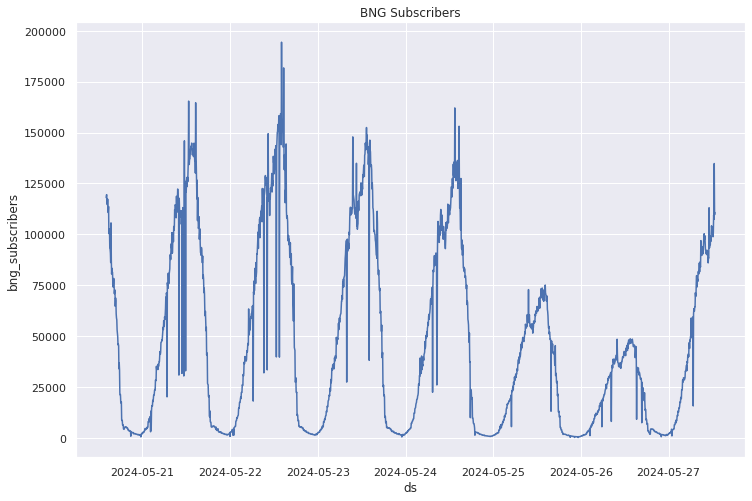

In [12]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:2000], y=metric_df['bng_subscribers'][:2000])
plt.title('BNG Subscribers')

# Rolling window and Z-Score

In this first approach, we will use a rolling window in which we will calculate the median of the values in such window, and then we will evaluate the standard deviation. We will use those to compute what is the "normal" range of values (above and below the median) to determine the acceptable operational range for our metric of interest, and identify the anomalous values.

In [13]:
ROLLING = 12
Z_SCORE_THRESHOLD = 3
PCTL_MULTIPLIER = 2

In [14]:
metric_df['SMA']=metric_df.loc[:,'y'].rolling(window=ROLLING).median()
metric_df['std']=metric_df.loc[:,'y'].rolling(window=ROLLING).std()

In [15]:
metric_df['SMA_diff']=metric_df['y']-metric_df['SMA']
metric_df['z_score']=metric_df['SMA_diff']/metric_df['std']

In [16]:
metric_df['z_anomaly']=(abs(metric_df['z_score'])>Z_SCORE_THRESHOLD).astype(int)

In [17]:
anomaly_df = metric_df[metric_df['z_anomaly']>0]

Text(0.5, 1.0, 'BNG Subscribers with anomalies')

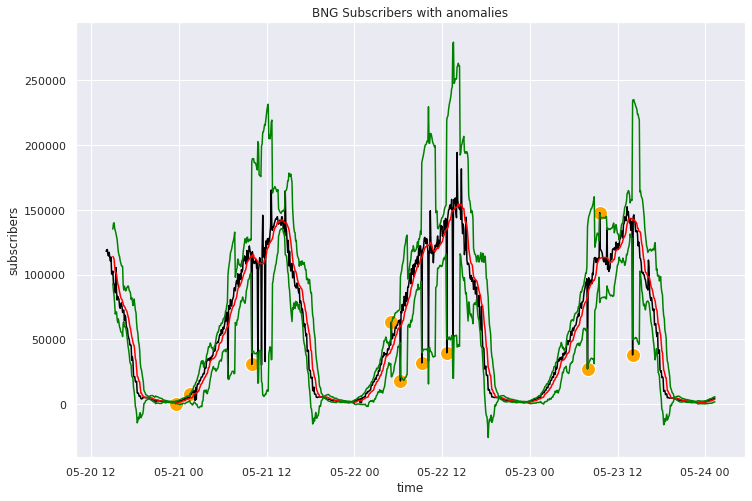

In [18]:

anomaly_mask = anomaly_df.ds < metric_df.loc[1000,'ds']
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['y'][:1000],color='black')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000],color='red')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]+Z_SCORE_THRESHOLD*metric_df['std'][:1000],color='green')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]-Z_SCORE_THRESHOLD*metric_df['std'][:1000],color='green')
sns.scatterplot(x=anomaly_df['ds'][anomaly_mask], y=anomaly_df['y'][anomaly_mask], color='orange',s=200)
plt.xlabel('time')
plt.ylabel('subscribers')
plt.title('BNG Subscribers with anomalies')

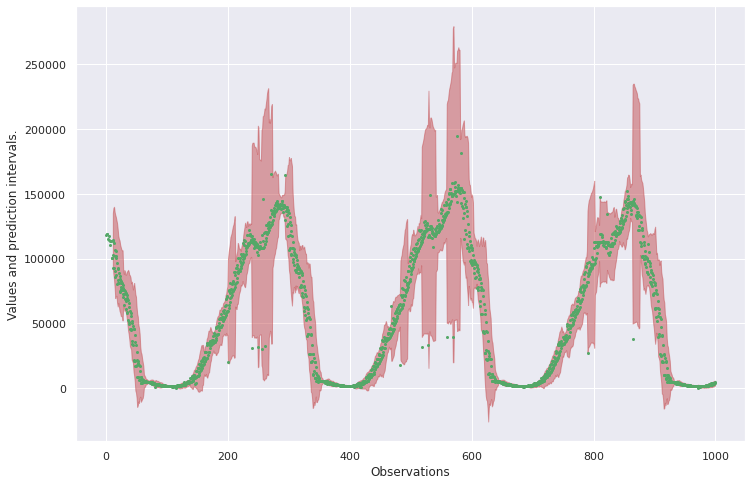

In [19]:
plt.plot(metric_df['y'][:1000],'go',markersize=2,label='Actual')
plt.plot(metric_df['SMA'][:1000],'go',markersize=2,label='Actual')
plt.fill_between(
       np.arange(1000), metric_df['SMA'][:1000]-Z_SCORE_THRESHOLD*metric_df['std'][:1000], metric_df['SMA'][:1000]+Z_SCORE_THRESHOLD*metric_df['std'][:1000], alpha=0.5, color="r",
label="Predicted interval")
plt.xlabel("Observations")
plt.ylabel("Values and prediction intervals.")
plt.show()

In [20]:
metric_df['pctl']= np.abs(metric_df['SMA_diff']).rolling(window=ROLLING).quantile(0.95,interpolation='lower')
metric_df['z_anomaly_2']=((np.abs(metric_df['SMA_diff'])/metric_df['pctl'])>PCTL_MULTIPLIER).astype(int)
anomaly_2_df = metric_df[metric_df['z_anomaly_2']>0]

Text(0.5, 1.0, 'BNG Subscribers with anomalies')

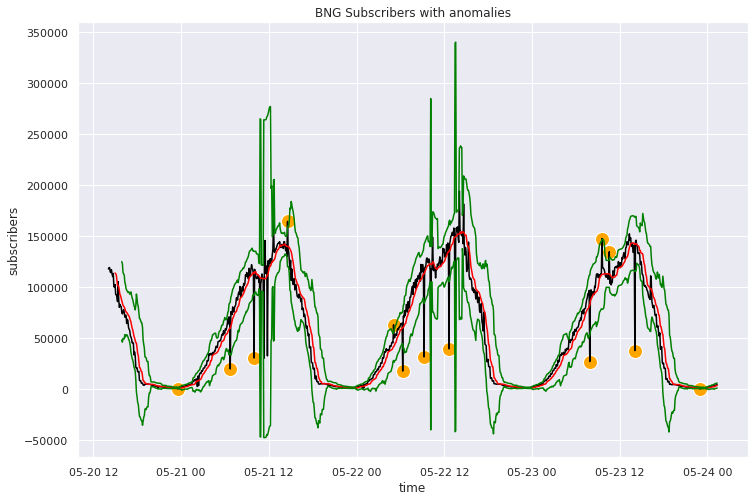

In [21]:
anomaly_mask = anomaly_2_df.ds < metric_df.loc[1000,'ds']
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['y'][:1000],color='black')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000],color='red')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]+PCTL_MULTIPLIER*metric_df['pctl'][:1000],color='green')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]-PCTL_MULTIPLIER*metric_df['pctl'][:1000],color='green')
sns.scatterplot(x=anomaly_2_df['ds'][anomaly_mask], y=anomaly_2_df['y'][anomaly_mask], color='orange',s=200)
plt.xlabel('time')
plt.ylabel('subscribers')
plt.title('BNG Subscribers with anomalies')

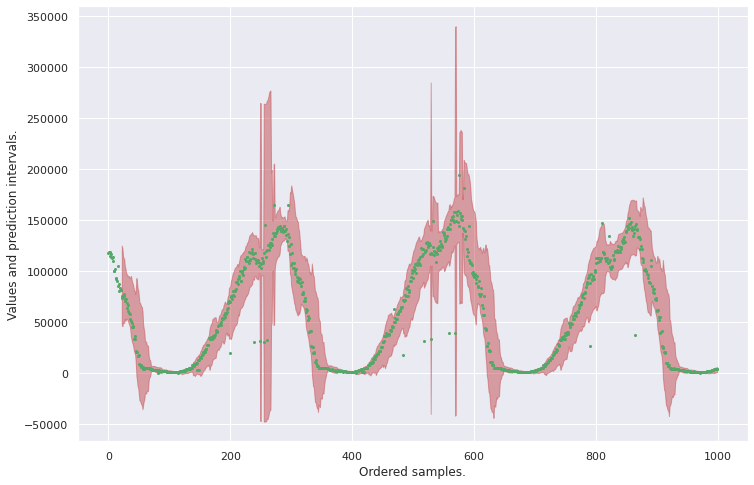

In [22]:
plt.plot(metric_df['y'][:1000],'go',markersize=2,label='Actual')
plt.fill_between(
       np.arange(1000), metric_df['SMA'][:1000]-PCTL_MULTIPLIER*metric_df['pctl'][:1000], metric_df['SMA'][:1000]+PCTL_MULTIPLIER*metric_df['pctl'][:1000], alpha=0.5, color="r",
label="Predicted interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.show()

# Prophet

In this section we will by applying Facebook's Prophet library to detect anomalies on the bng_subscribers metric

In [23]:
m = Prophet().fit(metric_df)

19:05:12 - cmdstanpy - INFO - Chain [1] start processing
19:05:12 - cmdstanpy - INFO - Chain [1] done processing


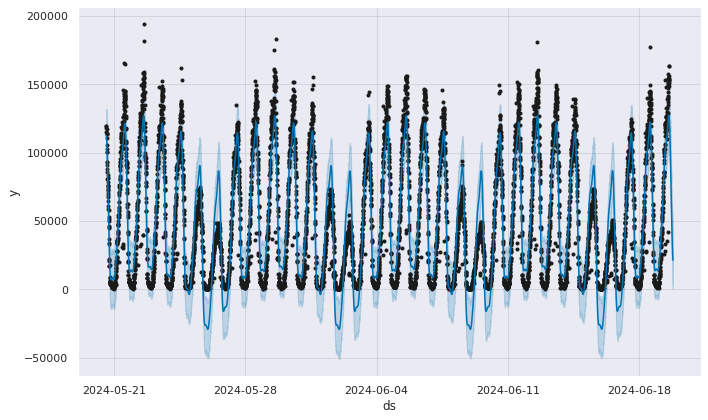

In [24]:
future = m.make_future_dataframe(periods=300, freq='min')
fcst = m.predict(future)
fig = m.plot(fcst)

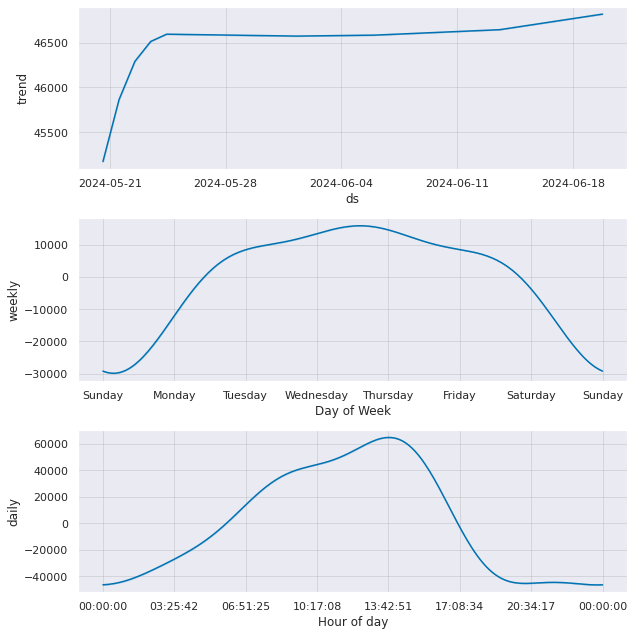

In [25]:
fig = m.plot_components(fcst)

In [26]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-05-20 14:03:54,45170.968096,92841.480440,132216.423912,45170.968096,45170.968096,67423.623869,67423.623869,67423.623869,63928.565150,63928.565150,63928.565150,3495.058719,3495.058719,3495.058719,0.0,0.0,0.0,112594.591965
1,2024-05-20 14:08:54,45173.448057,91492.429003,131774.620793,45173.448057,45173.448057,67107.135035,67107.135035,67107.135035,63549.327904,63549.327904,63549.327904,3557.807131,3557.807131,3557.807131,0.0,0.0,0.0,112280.583092
2,2024-05-20 14:13:54,45175.928018,91478.295686,131592.514737,45175.928018,45175.928018,66696.753481,66696.753481,66696.753481,63076.596758,63076.596758,63076.596758,3620.156723,3620.156723,3620.156723,0.0,0.0,0.0,111872.681499
3,2024-05-20 14:18:54,45178.407980,90174.372346,131895.606740,45178.407980,45178.407980,66190.358402,66190.358402,66190.358402,62508.250596,62508.250596,62508.250596,3682.107805,3682.107805,3682.107805,0.0,0.0,0.0,111368.766381
4,2024-05-20 14:23:54,45180.887941,89791.499524,130363.374301,45180.887941,45180.887941,65586.197746,65586.197746,65586.197746,61842.537030,61842.537030,61842.537030,3743.660716,3743.660716,3743.660716,0.0,0.0,0.0,110767.085687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8936,2024-06-19 18:59:54,46817.817132,319.053297,42045.838844,46817.817132,46817.817132,-24848.964924,-24848.964924,-24848.964924,-40437.157595,-40437.157595,-40437.157595,15588.192671,15588.192671,15588.192671,0.0,0.0,0.0,21968.852208
8937,2024-06-19 19:00:54,46817.836583,1560.470786,42004.325152,46817.836583,46817.836583,-25009.533555,-25009.533555,-25009.533555,-40595.507094,-40595.507094,-40595.507094,15585.973539,15585.973539,15585.973539,0.0,0.0,0.0,21808.303028
8938,2024-06-19 19:01:54,46817.856034,1986.490383,40241.239809,46817.856034,46817.856034,-25167.063728,-25167.063728,-25167.063728,-40750.810402,-40750.810402,-40750.810402,15583.746675,15583.746675,15583.746675,0.0,0.0,0.0,21650.792307
8939,2024-06-19 19:02:54,46817.875486,299.153186,40980.491317,46817.875486,46817.875486,-25321.573944,-25321.573944,-25321.573944,-40903.086029,-40903.086029,-40903.086029,15581.512085,15581.512085,15581.512085,0.0,0.0,0.0,21496.301542


In [27]:
# Merge actual and predicted values
combined_results = pd.merge(metric_df, fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')


In [28]:
combined_results['anomaly'] = combined_results.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
combined_results['anomaly'].value_counts()

0    7331
1    1310
Name: anomaly, dtype: int64

In [29]:
anomalies = combined_results[combined_results['anomaly']==1].sort_values(by='ds')
anomalies

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,...,std,SMA_diff,z_score,z_anomaly,pctl,z_anomaly_2,yhat,yhat_lower,yhat_upper,anomaly
200,1716291834,20084.810525,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,13402.123941,-39833.703828,-2.972193,0,12856.280226,1,67275.715757,47469.590006,88873.270491,1
227,1716299934,114545.206885,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,7619.549132,13138.841352,1.724359,0,12681.898722,0,94061.828725,72759.139580,113618.864536,1
231,1716301134,118687.143768,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,6592.386974,9687.932515,1.469564,0,12681.898722,0,96066.147307,76950.115731,116745.953676,1
234,1716302034,118148.557790,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,5006.861646,6715.896141,1.341338,0,12681.898722,0,97310.836332,75045.852149,117059.233118,1
235,1716302334,122251.591755,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,5028.780260,10000.898627,1.988732,0,12681.898722,0,97688.538957,78545.344684,117514.187554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8636,1718822634,155669.840830,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,4919.051184,1843.976192,0.374864,0,13822.853599,0,127259.573285,104839.727933,145918.696928,1
8637,1718822934,148365.143661,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,5053.163884,-5460.720977,-1.080654,0,12642.127385,0,127228.244279,105161.911639,147081.822355,1
8638,1718823234,154024.221948,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,5051.865490,104.632606,0.020712,0,12258.412110,0,127115.009724,107576.190358,147843.944004,1
8639,1718823534,151212.835369,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,5054.947983,-2706.753973,-0.535466,0,12258.412110,0,126916.466722,106903.058363,144788.152954,1


<AxesSubplot:xlabel='ds', ylabel='y'>

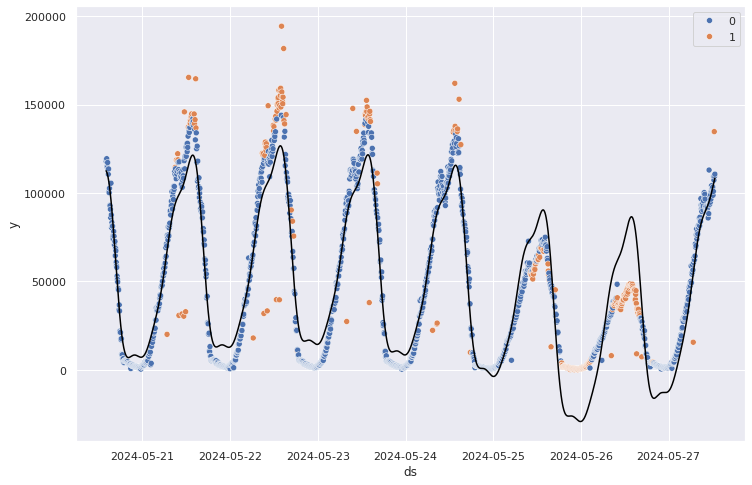

In [30]:
# Let's visualize the anomalies
sns.scatterplot(x='ds', y='y', data=combined_results[:2000], hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=combined_results[:2000], color='black')

# LSTM based autoencoder

We will start exploring the possibility to detect anomalies using Neural Networks and deep learning. In particular in this case, we will start with using a sequence based autoencoder. The sequence based aspect results in the approach of using LSTM. LSTM is well built for sequences, so the intuition says that it may be a good choice. However, it has been reported that LSTM does not work specially well with auto-regresive signals, so we will need to check how well in performs in our case.

In [31]:
time_steps = 72

In [32]:
train_pct = 0.95
train_size = int(metric_df.shape[0]*0.95)
test_size = metric_df.shape[0]-train_size

In [33]:
scaler = StandardScaler()
scaler = scaler.fit(metric_df[['y']])
metric_df['y_scaled']=scaler.transform(metric_df[['y']])


In [34]:
metric_df.y_scaled.shape

(8641,)

In [35]:
Xs, ys = [], []
for i in range(metric_df.shape[0] - time_steps):
    v = metric_df[['y_scaled']].iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(metric_df.y_scaled.iloc[i + time_steps-1])
x = np.array(Xs) 
y = np.array(ys)

In [36]:
x.shape

(8569, 72, 1)

In [37]:
y.shape

(8569,)

In [38]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed

model = Sequential()
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(units=128, return_sequences=True))
model.add(TimeDistributed(Dense(units=x_train.shape[2])))
model.add(Dropout(rate=0.2))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

2024-05-20 19:05:18.975845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 19:05:19.029963: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 72, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
filepath=join(path_files,"weights_autoencoder_auto_mse_best.keras")
checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')
print(checkpoint)
callbacks_list = [checkpoint]

In [42]:
filepath=join(path_files,"weights_autoencoder_auto_mse_best.weights.h5")
#model.load_weights(filepath)
#help(model.load_weights)
import os
current_working_directory = os.getcwd()
contents = os.listdir()
print("Current working directory:", current_working_directory)
print(contents)

Current working directory: /home/gpaasch/ml4nce/UC1
['weights_autoencoder_dense_mse_best.hdf5', 'bng_subscribers_metric.csv', 'UC1-time-anomaly-detection.ipynb', 'anomaly_model_autoencoder_best', '.ipynb_checkpoints', 'model.png', '.DS_Store', 'weights_autoencoder_auto_mse_best.keras']


In [43]:
history = model.fit(x_train,x_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.6413 - mse: 0.6413
Epoch 1: mse improved from inf to 0.51978, saving model to /home/gpaasch/ml4nce/UC1/weights_autoencoder_auto_mse_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - loss: 0.6393 - mse: 0.6393 - val_loss: 0.1409 - val_mse: 0.1409
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.4437 - mse: 0.4437
Epoch 2: mse improved from 0.51978 to 0.41567, saving model to /home/gpaasch/ml4nce/UC1/weights_autoencoder_auto_mse_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - loss: 0.4432 - mse: 0.4432 - val_loss: 0.1627 - val_mse: 0.1627
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.3916 - mse: 0.3916
Epoch 3: mse improved from 0.41567 to 0.38036, saving model to /home/gpaasch/ml4nce/UC1/weights_autoencoder_auto_mse_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - loss: 0.3914 - mse: 0.3914 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step -

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.2576 - mse: 0.2576
Epoch 24: mse did not improve from 0.24586
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - loss: 0.2574 - mse: 0.2574 - val_loss: 0.0595 - val_mse: 0.0595
Epoch 25/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.2504 - mse: 0.2504
Epoch 25: mse improved from 0.24586 to 0.24153, saving model to /home/gpaasch/ml4nce/UC1/weights_autoencoder_auto_mse_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - loss: 0.2502 - mse: 0.2502 - val_loss: 0.0507 - val_mse: 0.0507
Epoch 26/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2500 - mse: 0.2500
Epoch 26: mse did not improve from 0.24153
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - loss: 0.2499 - mse: 0.2499 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 27/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2630 - mse: 0.2630
Epoch 27: mse did not improve from 0.24153
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 0.2627 - mse: 0.2627 - val_loss: 0.0504 - val_mse: 0

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - loss: 0.2467 - mse: 0.2467 - val_loss: 0.0487 - val_mse: 0.0487


In [44]:
model.save_weights(filepath)

In [47]:
model.save(join(path_files,'anomaly_model_autoencoder_best.keras'))

In [48]:
# list all data available in history
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


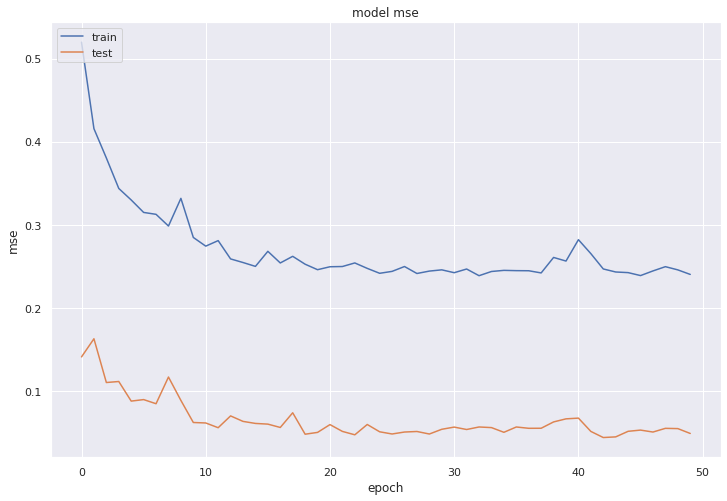

In [49]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



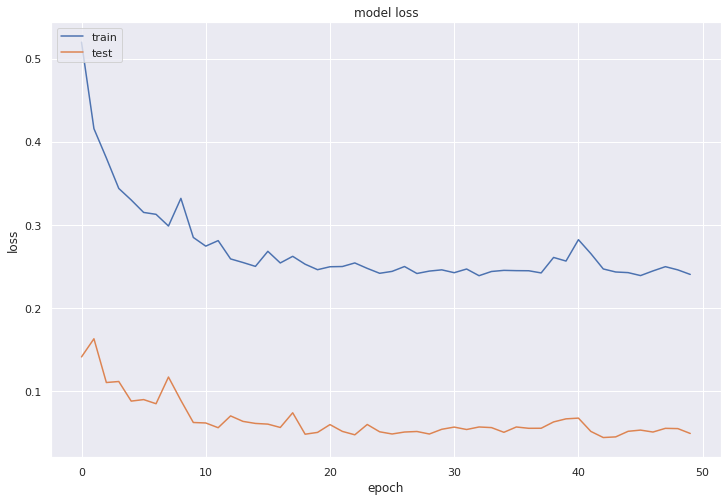

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
y_test_pred = model.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


In [52]:
score, acc = model.evaluate(x_test, x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1262 - mse: 0.1262


In [53]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.12206174433231354
Test accuracy: 0.12206175178289413


The "predicted" values are effectively vectors of lenght 72. 

In [54]:
y_test_pred.shape

(361, 72, 1)

In [55]:
y_test_pred_complete = y_test_pred

We are going to take only the last value of each vector as the "predicted" value from the model. We know it has predicted an entire vector, but for the purposes of visualizing the results of the model, we will use only the last value.

In [56]:
y_test_pred = y_test_pred[:,71,0]

In [57]:
y_test_pred.shape

(361,)

In [58]:
y_test_pred = y_test_pred.reshape(-1,1)

In [59]:
y_test.shape

(361,)

In [60]:
y_test = y_test.reshape(-1,1)

In [61]:
y_test.shape

(361, 1)

In [62]:
x_test.shape

(361, 72, 1)

In [63]:
test_mae_loss = np.abs(y_test_pred - y_test)


In [64]:
test_mae_loss.shape

(361, 1)

In [65]:
#test_mae_loss = np.mean(np.abs(y_test_pred - y_test), axis=1)
test_mae_loss = np.abs(y_test_pred - y_test)

THRESHOLD = np.percentile(test_mae_loss, 99)

test_score_df = pd.DataFrame(index=metric_df[(train_size + time_steps):].ds)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['y'] = y_test
test_score_df['y_pred']=y_test_pred

anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2024-06-18 09:03:54,1.281793,1.255344,True,-0.435609,0.846184
2024-06-18 13:03:54,1.464806,1.255344,True,-0.276892,1.187914
2024-06-19 09:18:54,1.320304,1.255344,True,-0.305963,1.014341
2024-06-19 12:03:54,1.414514,1.255344,True,-0.258088,1.156426


In [66]:
test_score_df

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2024-06-18 08:03:54,0.184918,1.255344,False,0.979439,0.794521
2024-06-18 08:08:54,0.215792,1.255344,False,1.028602,0.812810
2024-06-18 08:13:54,0.204435,1.255344,False,1.034963,0.830527
2024-06-18 08:18:54,0.185372,1.255344,False,1.032436,0.847064
2024-06-18 08:23:54,0.257019,1.255344,False,1.127020,0.870000
...,...,...,...,...,...
2024-06-19 13:43:54,0.608126,1.255344,False,2.327851,1.719725
2024-06-19 13:48:54,0.639851,1.255344,False,2.368392,1.728542
2024-06-19 13:53:54,0.485704,1.255344,False,2.208736,1.723032


<AxesSubplot:xlabel='ds', ylabel='loss'>

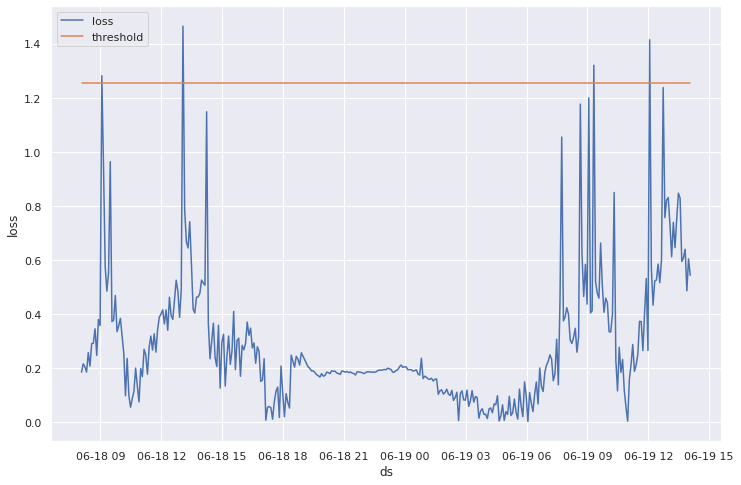

In [67]:
sns.lineplot(x= test_score_df.index, y= test_score_df.loss,label='loss')
sns.lineplot(x = test_score_df.index, y =test_score_df.threshold,label='threshold')

<AxesSubplot:xlabel='ds'>

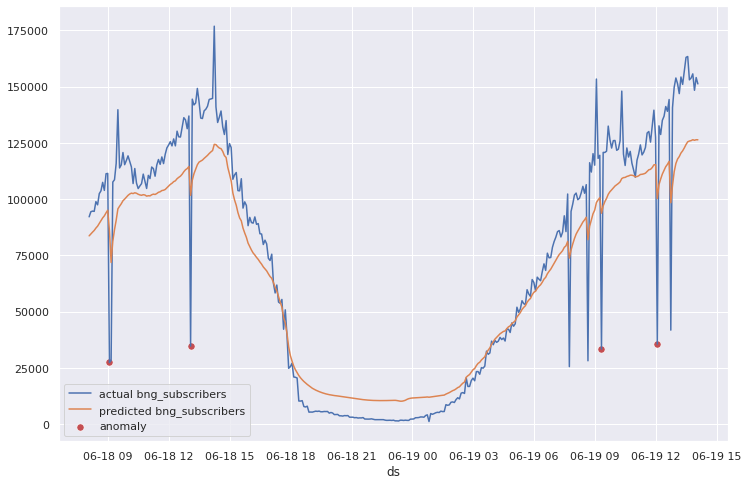

In [68]:
sns.lineplot(
      x= test_score_df.index, 
      y= scaler.inverse_transform(test_score_df.y.values.reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= test_score_df.index, 
      y= scaler.inverse_transform(test_score_df.y_pred.values.reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

sns.scatterplot(
      x= anomalies.index,
      y= scaler.inverse_transform(anomalies.y.values.reshape(1,-1)).reshape(-1),
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )

In [69]:
y_pred = model.predict(x)

268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step


In [70]:
y_pred=y_pred[:,-1,0]

In [71]:
y_pred=y_pred.reshape(-1,1)

In [72]:
y = y.reshape(-1,1)
mae_loss = np.abs(y_pred - y)

mae_threshold = np.percentile(mae_loss, 99)

score_df = pd.DataFrame(index=metric_df[(time_steps):].ds)
score_df['loss'] = mae_loss
score_df['threshold'] = mae_threshold
score_df['anomaly'] = score_df.loss > score_df.threshold
score_df['y'] = y
score_df['y_pred']=y_pred

total_anomalies = score_df[score_df.anomaly == True]
total_anomalies.head()

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2024-05-21 10:03:54,1.416385,0.902455,True,-0.360776,1.055609
2024-05-21 10:53:54,1.297427,0.902455,True,-0.342655,0.954773
2024-05-21 11:23:54,1.250544,0.902455,True,-0.370653,0.879891
2024-05-21 11:33:54,1.073087,0.902455,True,2.155374,1.082287
2024-05-21 11:53:54,1.286188,0.902455,True,-0.315156,0.971032


<AxesSubplot:xlabel='ds', ylabel='loss'>

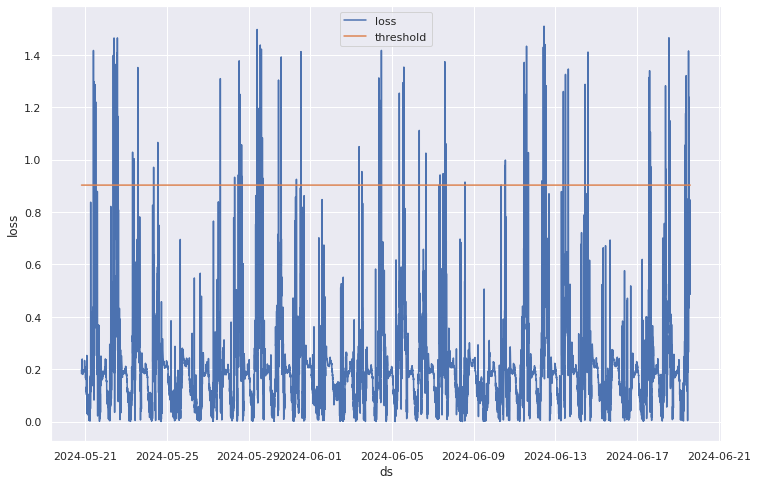

In [73]:
sns.lineplot(x= score_df.index, y= score_df.loss,label='loss')
sns.lineplot(x = score_df.index, y =score_df.threshold,label='threshold')

<AxesSubplot:xlabel='ds'>

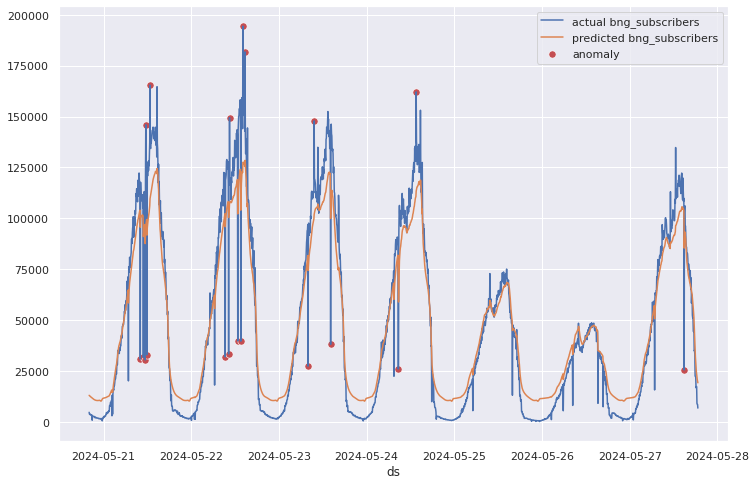

In [74]:
scope = 2000
scope_time = score_df.index[scope]
anomaly_scope = total_anomalies.index <= scope_time
sns.lineplot(
      x= score_df[:scope].index, 
      y= scaler.inverse_transform(score_df[:scope].y.values.reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= score_df[:scope].index, 
      y= scaler.inverse_transform(score_df[:scope].y_pred.values.reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

sns.scatterplot(
      x= total_anomalies[anomaly_scope].index,
      y= scaler.inverse_transform(total_anomalies[anomaly_scope].y.values.reshape(1,-1)).reshape(-1),
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )

# Feed Forward Dense layers based Autoencoder

In [75]:
time_steps = 2016


In [76]:
Xs, ys = [], []
for i in range(metric_df.shape[0] - time_steps):
    v = metric_df[['y_scaled']].iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(metric_df.y_scaled.iloc[i + time_steps-1])
x = np.array(Xs) 
y = np.array(ys)

In [77]:
x.shape

(6625, 2016, 1)

In [78]:
y.shape

(6625,)

In [79]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [80]:
#find_me
model = keras.Sequential()

model.add(keras.layers.Dense(units=1024,input_shape=(x_train.shape[1],),activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=x_train.shape[1]))
model.add(keras.layers.Dropout(rate=0.2))

opt = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='mse',optimizer =opt,metrics=['mse'])

/home/gpaasch/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1024)           │     2,065,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2016)           │     1,034,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2016)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,756,128 (14.33 MB)

 Trainable params: 3,756,128 (14.33 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
filepath=join(path_files,"weights_autoencoder_dense_mse_best.keras")
checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [84]:
history = model.fit(x_train,x_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7239 - mse: 0.7239
Epoch 1: mse improved from inf to 0.58094, saving model to /home/gpaasch/ml4nce/UC1/weights_autoencoder_dense_mse_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.7210 - mse: 0.7210 - val_loss: 0.2912 - val_mse: 0.2912
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4511 - mse: 0.4511
Epoch 2: mse improved from 0.58094 to 0.44001, saving model to /home/gpaasch/ml4nce/UC1/weights_autoencoder_dense_mse_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.4508 - mse: 0.4508 - val_loss: 0.2594 - val_mse: 0.2594
Epoch 3/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4424 - mse: 0.4424
Epoch 3: mse did not improve from 0.44001
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4424 - mse: 0.4424 - val_loss: 0.2932 - val_mse: 0.2932
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4496 - mse: 0.4496
Epoch 4: mse did not improve from 0.44001
47/47 ━━━━━━━━━━━━━━━━━━

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2765 - mse: 0.2765 - val_loss: 0.0931 - val_mse: 0.0931
Epoch 25/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2755 - mse: 0.2755
Epoch 25: mse improved from 0.27476 to 0.27422, saving model to /home/gpaasch/ml4nce/UC1/weights_autoencoder_dense_mse_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2755 - mse: 0.2755 - val_loss: 0.0907 - val_mse: 0.0907
Epoch 26/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2748 - mse: 0.2748
Epoch 26: mse improved from 0.27422 to 0.27374, saving model to /home/gpaasch/ml4nce/UC1/weights_autoencoder_dense_mse_best.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2748 - mse: 0.2748 - val_loss: 0.0908 - val_mse: 0.0908
Epoch 27/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2760 - mse: 0.2760
Epoch 27: mse did not improve from 0.27374
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2760 - mse: 0.2760 - val_loss: 0.1140 - val_mse: 0.1140
Epoch 28/50
47/47 ━━━━━━━━━━━━

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2696 - mse: 0.2696 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 49/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2720 - mse: 0.2720
Epoch 49: mse did not improve from 0.25949
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2720 - mse: 0.2720 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 50/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2724 - mse: 0.2724
Epoch 50: mse did not improve from 0.25949
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2724 - mse: 0.2724 - val_loss: 0.1005 - val_mse: 0.1005


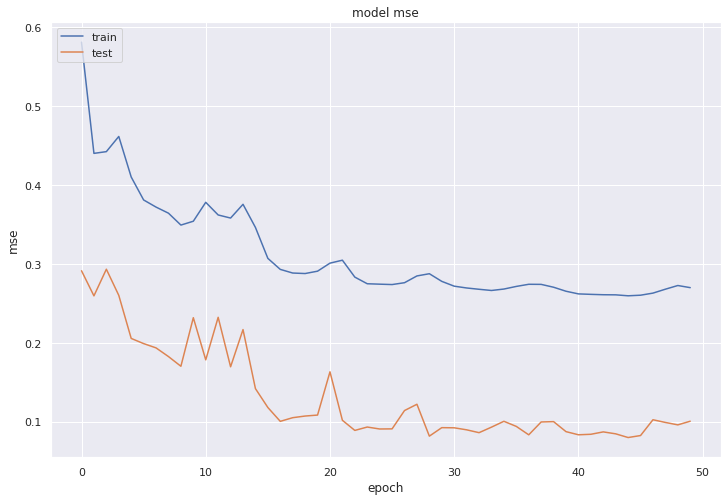

In [85]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
filepath=join(path_files,"weights_autoencoder_dense_mse_best.weights.h5")
model.save_weights(filepath)

In [89]:
y_pred = model.predict(x)

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [90]:
y_pred.shape

(6625, 2016)

In [91]:
y_pred=y_pred[:,-1]

In [92]:
y_pred.shape

(6625,)

In [93]:
y_pred=y_pred.reshape(-1,1)
y = y.reshape(-1,1)

In [94]:

mae_loss = np.abs(y_pred - y)

mae_threshold = np.percentile(mae_loss, 99)

score_df = pd.DataFrame(index=metric_df[(time_steps):].ds)
score_df['loss'] = mae_loss
score_df['threshold'] = mae_threshold
score_df['anomaly'] = score_df.loss > score_df.threshold
score_df['y'] = y
score_df['y_pred']=y_pred

total_anomalies = score_df[score_df.anomaly == True]
total_anomalies.head()

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2024-05-27 14:53:54,1.371865,1.023625,True,-0.477693,0.894172
2024-05-28 07:38:54,1.231400,1.023625,True,-0.498122,0.733278
2024-05-28 12:58:54,1.766158,1.023625,True,-0.252415,1.513742
2024-05-28 13:48:54,1.656604,1.023625,True,-0.125807,1.530797
2024-05-28 15:48:54,1.354306,1.023625,True,-0.446457,0.907848


<AxesSubplot:xlabel='ds', ylabel='loss'>

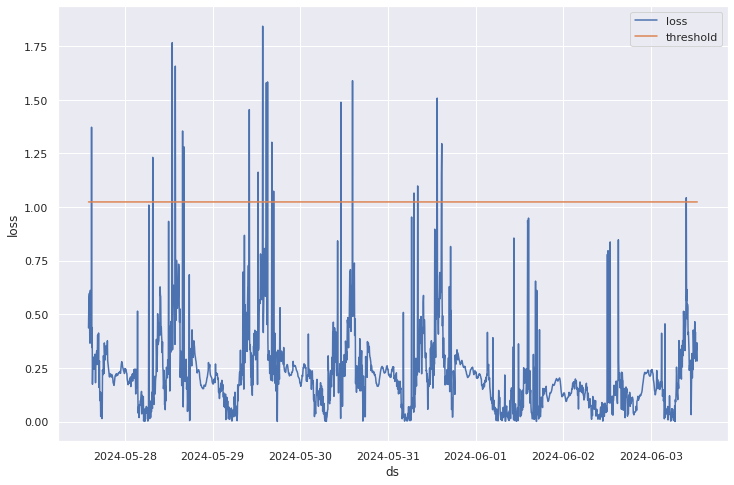

In [95]:
sns.lineplot(x= score_df[:scope].index, y= score_df[:scope].loss,label='loss')
sns.lineplot(x = score_df[:scope].index, y =score_df[:scope].threshold,label='threshold')

<AxesSubplot:xlabel='ds'>

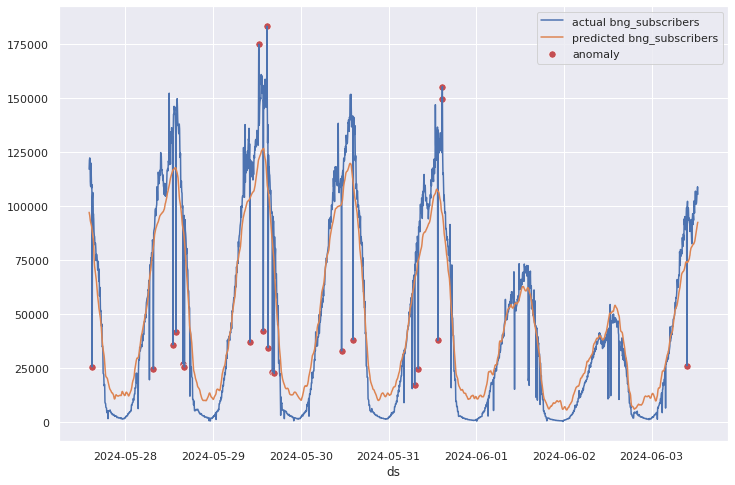

In [96]:
scope = 2000
scope_time = score_df.index[scope]
anomaly_scope = total_anomalies.index <= scope_time
sns.lineplot(
      x= score_df[:scope].index, 
      y= scaler.inverse_transform(score_df[:scope].y.values.reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= score_df[:scope].index, 
      y= scaler.inverse_transform(score_df[:scope].y_pred.values.reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

sns.scatterplot(
      x= total_anomalies[anomaly_scope].index,
      y= scaler.inverse_transform(total_anomalies[anomaly_scope].y.values.reshape(1,-1)).reshape(-1),
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )